# Google BigQuery

* Motivated by the structure in the OKCupid usernames, I looked at the reddit data on Google BigQuery.
* Try to answer the questions: 
    * Can we estimate the age distribution of users on reddit from just their usernames?
    * Can we find changes in the age of reddit users since 2007?
    


In [513]:
%matplotlib inline
import os
import glob
import pylab
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 5)
import seaborn as sns
sns.set_style('whitegrid')

from pysurvey.plot import setup_sns as setup
from pysurvey.plot import minmax, icolorbar, density, legend

Had to impose a limit so that I did not have to spin up a dataset or something with google.

Decided to spin up a dataset and see how well this really works.  Google -- thanks for the free trial!

There are a few cohort tables that are a bit more detailed and would be good to use.  They have been built for the following months:

* cohorts_201505
* cohorts_201508
* cohorts_201510
* cohorts_201512

I have some decent compute nodes at my disposal so lets do the clean up and visualization here.

In [134]:
titles = []
dfs = []
for filename in glob.glob('/Users/ajmendez/data/reddit/*.csv'):
    titles.append(int(os.path.splitext(os.path.basename(filename))[0]))
    
    df = pd.read_csv(filename)
    tmp = df['author'].str.extract((u'(\d+)'))
    df['number'] = tmp.apply(lambda x: int(x) if isinstance(x, (str, unicode)) else np.nan)
    df['nlength'] = tmp.apply(lambda x: len(x) if isinstance(x, (str,unicode)) else 0)
    dfs.append(df)
print('Found Years: {}'.format(', '.join(map(str, titles))))

Found Years: 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014


# Yearly Data


2007 [42  0 99 11 22 77 13 12  1 21] [51 49 48 47 44 42 40 40 40 35]
2008 [99 12 13 23  0 77 42 11  1 22] [209 187 172 171 163 162 159 156 145 143]
2009 [12 11  1 23  9 13 22 99  0 77] [832 664 661 626 592 591 590 559 504 498]
2010 [12 11 22 10  1  0 23 13 88 99] [1883 1575 1483 1455 1426 1354 1354 1335 1194 1162]
2011 [11 12 13 22 23 88  0  1 21 99] [4417 4310 3905 3378 3255 3154 2966 2642 2609 2595]
2012 [12 13 11 69 22 23 88 21  0 10] [11543 10012  8836  7565  7544  7509  6965  6264  5948  5609]
2013 [13 12 11 23 69 22 88 21  0 10] [17220 16398 12786 12181 12151 11529 10720  9991  9048  8931]
2014 [12 13 11 69 23 22 88 21 10  0] [21692 21337 17203 16936 16132 15426 14302 13116 12386 12346]


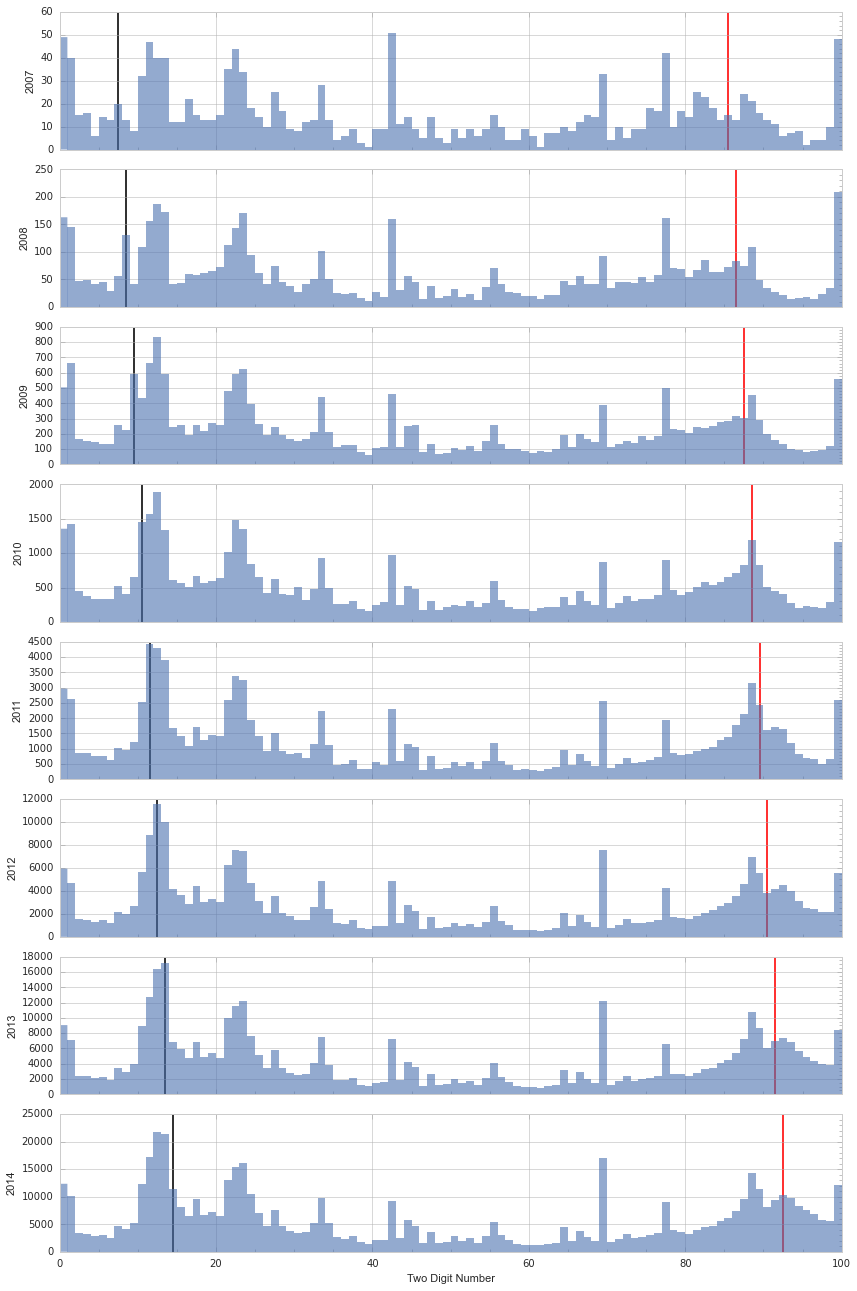

In [514]:
bins = np.arange(0, 101,1)
setup(figsize=(12, 18))

for i, (title,df) in enumerate(zip(titles,dfs)):
    ax = setup(subplt=(len(titles),1,i+1),
               ylabel=title, 
               xlabel='Two Digit Number', xticks=(i==len(titles)-1))
    
    isdigits = (df['nlength'] == 2)
    x = df.loc[isdigits, 'number'].as_matrix()
    pylab.axvline(titles[i]-2000 + 0.5, lw=2, alpha=0.8, zorder=-2, color='k')
    pylab.axvline(titles[i]-22-1900 + 0.5, lw=2, alpha=0.8, zorder=-2, color='r')
    
    pylab.hist(x, bins=bins, alpha=0.6, lw=0)
    v,l = np.histogram(x, bins)
    ii = np.argsort(-v)[:10]
    print title, l[ii], v[ii]

pylab.tight_layout()

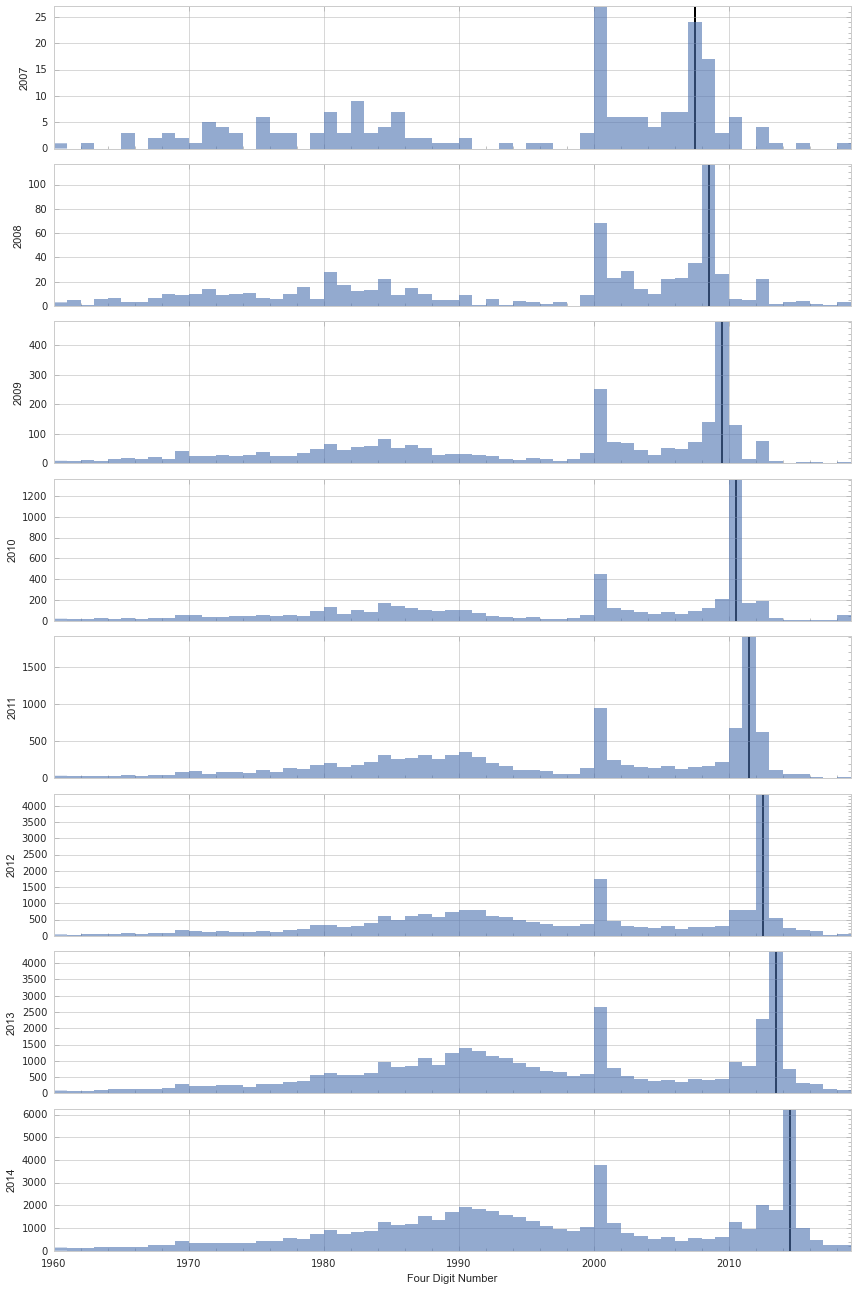

In [515]:
bins = np.arange(1960, 2020, 1)
setup(figsize=(12, 18))
for i, (title, df) in enumerate(zip(titles, dfs)):
    ax = setup_plot(subplt=(len(titles),1,i+1), 
               ylabel=titles[i], #ylog=True, yr=[1, 1e4],
               xr=minmax(bins), xlabel='Four Digit Number', xticks=i==len(titles)-1)
    isdigits = (df['nlength'] == 4)
    pylab.axvline(title + 0.5, zorder=-2, lw=2, color='k')
    pylab.hist(df.loc[isdigits, 'number'].as_matrix(), bins=bins, alpha=0.6, lw=0)
pylab.tight_layout()

In [516]:
def make_bins(xr, yr, ndigit=2):
    x,y = np.arange(xr[0],xr[1]+2), np.arange(yr[0], yr[1]+2), 
    X,Y = np.meshgrid(x*1.0,y*1.0)
    Z = np.zeros( (len(x)-1, len(y)-1) )
    for i,df in enumerate(dfs):
        isdigits = (df['nlength'] == ndigit)
        tmp = df.loc[isdigits, 'number'].as_matrix()
        Z[:, i] = np.histogram(tmp, bins=x, density=True)[0]
    return X, Y, np.ma.MaskedArray(Z, Z==0)

xr = [0,101]
yr = [2007, 2014]
X,Y,Z = make_bins(xr, yr)

# Two Digit Numbers

* Having a few years of comments, lets look at changes in the distribution.

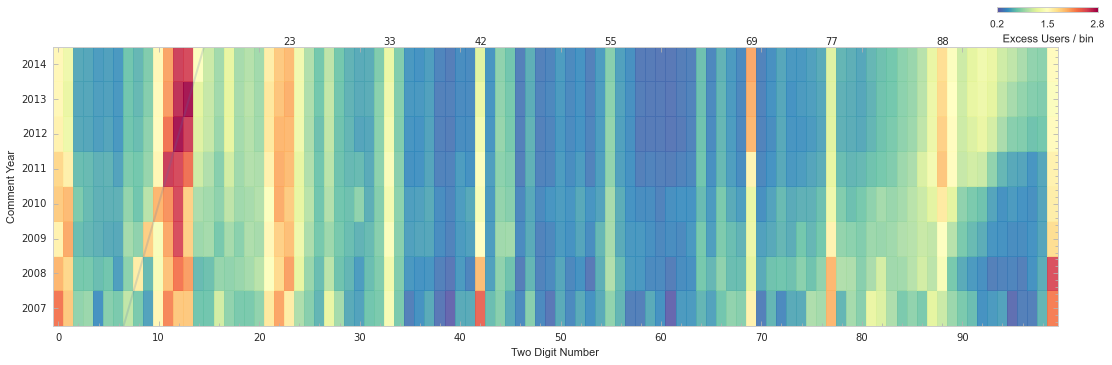

In [517]:
years = np.arange(2007, 2015)

setup_plot(figsize=(18,5), 
      xr=[0,100], xlabel='Two Digit Number',
      xtickv=np.arange(0,101, 10) + 0.5, xticknames=np.arange(0,101, 10),
      ylabel='Comment Year', ytickv=years+0.5, yticknames=titles,)
_ = pylab.pcolormesh(X,Y,Z.T, label='Fraction of Users / bin',
                     vmin=0, vmax=0.04,
                     zorder=-2, alpha=0.9, cmap=pylab.cm.Spectral_r)
icolorbar(pcm, loc=1, borderpad=-4, tickfmt='{:.1f}', width='10%')

years = np.arange(2007, 2016)
pylab.plot(years-2000, years, lw=2, alpha=0.2)

numbers = [42, 69, 77, 33, 23, 88, 55]
for number in numbers:
    pylab.text(number+0.5, 2015, number, ha='center', va='bottom')

# Two Digit Excess

* Lets define the excess popuation relative to the mean as this change we would like to measure

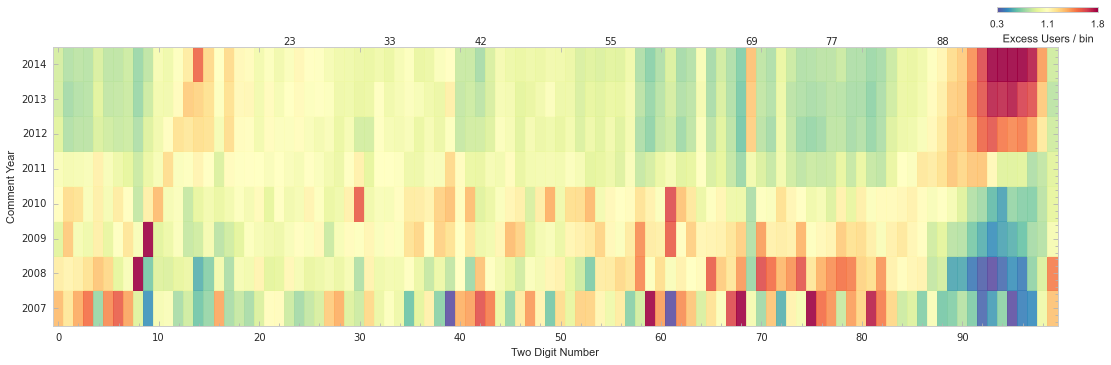

In [518]:
NZ = np.ma.MaskedArray(Z.T/np.mean(Z, axis=1), Z.T==0)
setup_plot(figsize=(18,5), 
      xr=[0,100], xlabel='Two Digit Number',
      xtickv=np.arange(0,101, 10) + 0.5, xticknames=np.arange(0,101, 10),
      ylabel='Comment Year', ytickv=years+0.5, yticknames=titles,)
pcm = pylab.pcolormesh(X,Y,NZ, label='Excess Users / bin',
                     vmin=0.3, vmax=1.8,
                     zorder=-2, alpha=0.9, cmap=pylab.cm.Spectral_r)
icolorbar(pcm, loc=1, borderpad=-4, tickfmt='{:.1f}', width='10%')

numbers = [42, 69, 77, 33, 23, 88, 55]
for number in numbers:
    pylab.text(number+0.5, 2015, number, ha='center', va='bottom')

# Four Digit Numbers

In [525]:
four_xr = [1960,2021]
four_X,four_Y,four_Z = make_bins(four_xr, yr, ndigit=4)

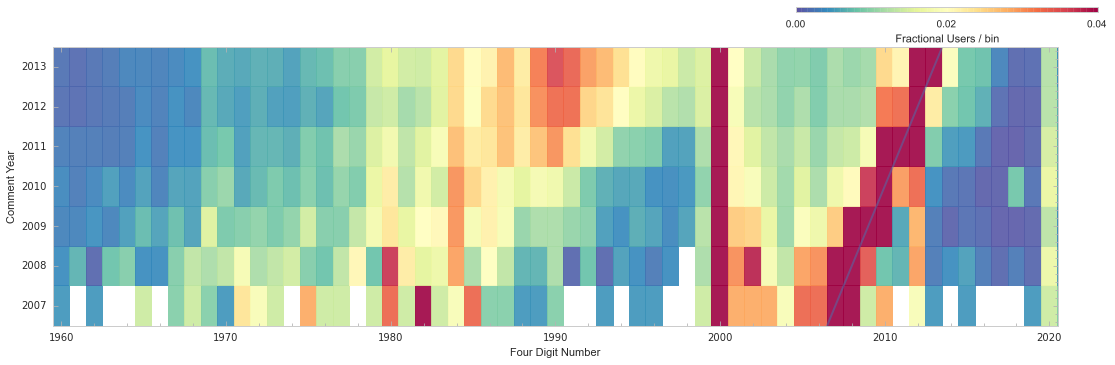

In [531]:
years = np.arange(2007, 2015)

setup_plot(figsize=(18,5), 
      xr=four_xr, xlabel='Four Digit Number',
      xtickv=np.arange(1960,2021, 10) + 0.5, xticknames=np.arange(1960,2021, 10),
      yr=yr, ylabel='Comment Year', ytickv=years+0.5, yticknames=titles,)
pcm = pylab.pcolormesh(four_X, four_Y, four_Z.T,  label='Fractional Users / bin',
                       vmin=0, vmax=0.04,
                       zorder=-2, alpha=0.9, cmap=pylab.cm.Spectral_r)
icolorbar(pcm, loc=1, borderpad=-4, tickfmt='{:.2f}')

years = np.arange(2007, 2016)
pylab.plot(years, years, lw=2, alpha=0.5)

# numbers = [42, 69, 77, 33, 23, 88, 55]
# for number in numbers:
#     pylab.text(number+0.5, 2015, number, ha='center', va='bottom')

# Excess Four Digit Numbers

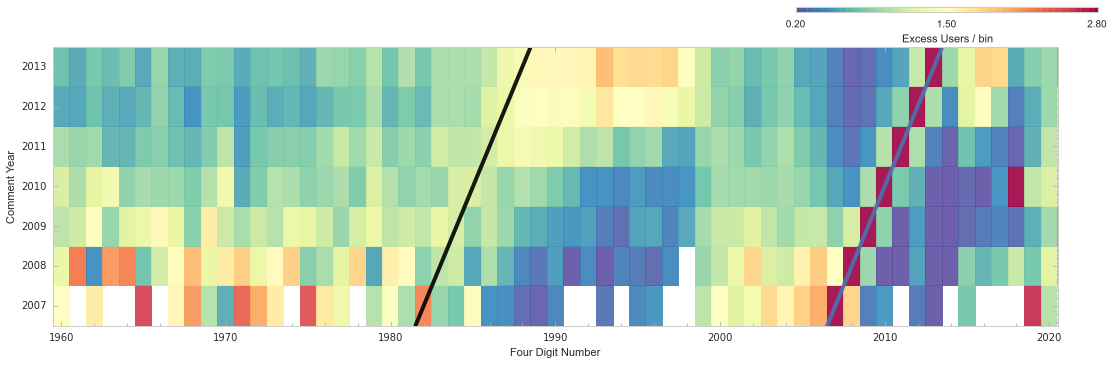

In [536]:
years = np.arange(2007, 2015)
four_NZ = np.ma.MaskedArray(four_Z.T/np.mean(four_Z, axis=1), four_Z.T==0)
setup_plot(figsize=(18,5), 
      xr=four_xr, xlabel='Four Digit Number',
      xtickv=np.arange(1960,2021, 10) + 0.5, xticknames=np.arange(1960,2021, 10),
      yr=yr, ylabel='Comment Year', ytickv=years+0.5, yticknames=titles,)
pcm = pylab.pcolormesh(four_X, four_Y, four_NZ,  label='Excess Users / bin',
                       vmin=0.2, vmax=2.8,
                       zorder=-2, alpha=0.9, cmap=pylab.cm.Spectral_r)
icolorbar(pcm, loc=1, borderpad=-4, tickfmt='{:.2f}')
pylab.plot(years, years, lw=4, alpha=0.9)
pylab.plot(years-25, years, lw=4, alpha=0.9, color='k')


In [507]:
df = dfs[-1]
isgood = ( (df['nlength'] == 4) & (dfs[-1]['number'] == 1960) )
df.loc[isgood, 'author']

24748           jiohdi1960
157067     elmergantry1960
                ...       
6358274          yonda1960
6423791          chico1960
Name: author, dtype: object

# Cohort Analysis

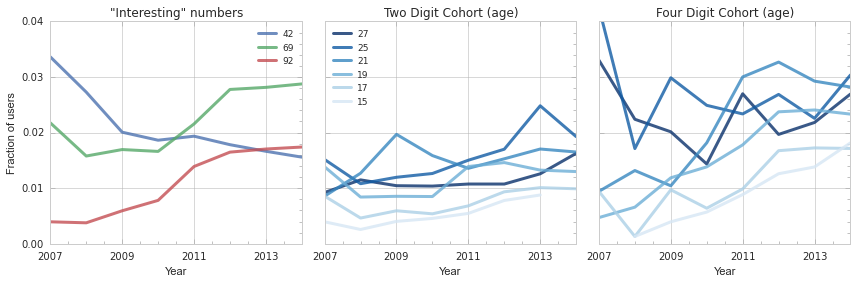

In [529]:
narr = np.arange(0,101)
numbers = [42, 69, 92]
setup_plot(figsize=(12,4), subplt=(1,3,1), title='"Interesting" numbers',
      xr=yr, xlabel='Year', xtickv=np.arange(2007,2015,2), xticknames=np.arange(2007,2015,2), 
      yr=[0,0.04], ytickv=np.arange(0,0.041,0.01), ylabel='Fraction of users', )
for number in numbers:
    i = np.where(number == narr)[0]
    pylab.plot(Y[:-1,i], Z.T[:,i], lw=3, alpha=0.8, label=number)
legend(loc=1, alpha=0.8)



numbers = [1980, 1982, 1986, 1988, 1990, 1992]

# people use 99 in excess of years, so disable for plot
Z99 = Z.T.view()
Z99[:,-3:] = np.nan
setup_plot(subplt=(1,3,2), yticks=False, title='Two Digit Cohort (age)', 
      xr=yr, xlabel='Year', xtickv=np.arange(2007,2015,2), xticknames=np.arange(2007,2015,2), 
      yr=[0,0.04], ytickv=np.arange(0,0.041,0.01), ylabel='Fraction of users', )
for k,number in enumerate(numbers):
    i = np.arange(8)
    j = np.where(number-1900 == narr)[0]
    pylab.plot(Y[:-1,j], Z99[i,j+i], lw=3, alpha=0.8, 
               label=2007-number, color=pylab.cm.Blues_r(k*1.0/len(numbers))) 
legend(loc=2, alpha=0.8)

    
    
narr = np.arange(1960,2020)
setup_plot(subplt=(1,3,3), yticks=False, title='Four Digit Cohort (age)',
      xr=yr, xlabel='Year', xtickv=np.arange(2007,2015,2), xticknames=np.arange(2007,2015,2), 
      yr=[0,0.04], ytickv=np.arange(0,0.041,0.01), ylabel='Fraction of users', )
for k,number in enumerate(numbers):
    i = np.arange(8)
    j = np.where(number == narr)[0]
    pylab.plot(Y[:-1,j], four_Z.T[i,j+i], lw=3, alpha=0.8, 
               label=2007-number, color=pylab.cm.Blues_r(k*1.0/len(numbers)))
# legend(loc=2, alpha=0.8)

pylab.tight_layout()

In [410]:
2015-1992, 2015-1980

(23, 35)